<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Evaluating Classification Models on Humor Styles Data

---

In this lab you will be practicing evaluating classification models (Logistic Regression in particular) on a "Humor Styles" survey.

This survey is designed to evaluate what "style" of humor subjects have. Your goal will be to classify gender using the responses on the survey.

## Humor styles questions encoding reference

### 32 questions:

Subjects answered **32** different questions outlined below:

    1. I usually don't laugh or joke with other people.
    2. If I feel depressed, I can cheer myself up with humor.
    3. If someone makes a mistake, I will tease them about it.
    4. I let people laugh at me or make fun of me at my expense more than I should.
    5. I don't have to work very hard to make other people laugh. I am a naturally humorous person.
    6. Even when I'm alone, I am often amused by the absurdities of life.
    7. People are never offended or hurt by my sense of humor.
    8. I will often get carried away in putting myself down if it makes family or friends laugh.
    9. I rarely make other people laugh by telling funny stories about myself.
    10. If I am feeling upset or unhappy I usually try to think of something funny about the situation to make myself feel better.
    11. When telling jokes or saying funny things, I am usually not concerned about how other people are taking it.
    12. I often try to make people like or accept me more by saying something funny about my own weaknesses, blunders, or faults.
    13. I laugh and joke a lot with my closest friends.
    14. My humorous outlook on life keeps me from getting overly upset or depressed about things.
    15. I do not like it when people use humor as a way of criticizing or putting someone down.
    16. I don't often say funny things to put myself down.
    17. I usually don't like to tell jokes or amuse people.
    18. If I'm by myself and I'm feeling unhappy, I make an effort to think of something funny to cheer myself up.
    19. Sometimes I think of something that is so funny that I can't stop myself from saying it, even if it is not appropriate for the situation.
    20. I often go overboard in putting myself down when I am making jokes or trying to be funny.
    21. I enjoy making people laugh.
    22. If I am feeling sad or upset, I usually lose my sense of humor.
    23. I never participate in laughing at others even if all my friends are doing it.
    24. When I am with friends or family, I often seem to be the one that other people make fun of or joke about.
    25. I donít often joke around with my friends.
    26. It is my experience that thinking about some amusing aspect of a situation is often a very effective way of coping with problems.
    27. If I don't like someone, I often use humor or teasing to put them down.
    28. If I am having problems or feeling unhappy, I often cover it up by joking around, so that even my closest friends don't know how I really feel.
    29. I usually can't think of witty things to say when I'm with other people.
    30. I don't need to be with other people to feel amused. I can usually find things to laugh about even when I'm by myself.
    31. Even if something is really funny to me, I will not laugh or joke about it if someone will be offended.
    32. Letting others laugh at me is my way of keeping my friends and family in good spirits.

---

### Response scale:

For each question, there are 5 possible response codes ("likert scale") that correspond to different answers. There is also a code that indicates there is no response for that subject.

    1 == "Never or very rarely true"
    2 == "Rarely true"
    3 == "Sometimes true"
    4 == "Often true"
    5 == "Very often or always true
    [-1 == Did not select an answer]
    
---

### Demographics:

    age: entered as as text then parsed to an interger.
    gender: chosen from drop down list (1=male, 2=female, 3=other, 0=declined)
    accuracy: How accurate they thought their answers were on a scale from 0 to 100, answers were entered as text and parsed to an integer. They were instructed to enter a 0 if they did not want to be included in research.	

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

### 1. Load the data and perform any EDA and cleaning you think is necessary.

It is worth reading over the description of the data columns above for this.

In [3]:
hsq = pd.read_csv('../../../../../resource-datasets/humor_styles/hsq_data.csv')

In [4]:
# correct spelling
hsq.rename(columns={'agressive': 'aggressive'}, inplace=True)

In [5]:
hsq.shape

(1071, 39)

In [6]:
# looks like there are 4 genders but most are just male and female
print(hsq.gender.unique())
print(hsq.gender.value_counts())

[2 1 3 0]
1    581
2    477
3      8
0      5
Name: gender, dtype: int64


In [7]:
# Set any of the -1 values in the question answers to np.nan
for col in [c for c in hsq.columns if c.startswith('Q')]:
    hsq[col] = hsq[col].map(lambda x: np.nan if x == -1 else x)

In [8]:
# check null values:
hsq.isnull().sum()

Q1                3
Q2                3
Q3                2
Q4                1
Q5                2
Q6                2
Q7                2
Q8                7
Q9                4
Q10               3
Q11               2
Q12               2
Q13               2
Q14               4
Q15               7
Q16               5
Q17              13
Q18               6
Q19               4
Q20               6
Q21               8
Q22               7
Q23               8
Q24               7
Q25              10
Q26               9
Q27               5
Q28               4
Q29               6
Q30               8
Q31               7
Q32               3
affiliative       0
selfenhancing     0
aggressive        0
selfdefeating     0
age               0
gender            0
accuracy          0
dtype: int64

In [9]:
# drop the nulls
hsq.dropna(inplace=True)
print(hsq.shape)

(993, 39)


In [10]:
hsq.age.unique()

array([   25,    44,    50,    52,    30,    27,    34,    18,    33,
          26,    36,    21,    20,    23,    70,    17,    39,    61,
          29,    16,    69,    22,    38,    24,    14,    40,    62,
          51,    35,    46,    42,    19,    32,    15,    37,    45,
          28,    49,    31,    64,    54,    68,    48,    60,    43,
          41,    53,    58,   242,   151,    55,    67,    56,    59,
          66,    47,  2670,    57, 44849])

In [11]:
# set hsq to be only valid ages:
hsq = hsq[hsq.age <= 100]

In [12]:
# only keep male and female
hsq = hsq[hsq.gender.isin([1, 2])]

### 2. Set up a predictor matrix to predict `gender` (only male vs. female)

Choice of predictors is up to you. Justify which variables you include.

In [13]:
# not including the "aggregate" measures (affiliative, selfenhancing, etc.) as they are combinations
# of the original questions.
predictors = [x for x in hsq.columns if 'Q' in x]
predictors = predictors + ['age', 'accuracy']
print(predictors)

['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q30', 'Q31', 'Q32', 'age', 'accuracy']


In [14]:
# set up y variable
y = hsq.gender.map(lambda x: 1 if x == 1 else 0)

In [15]:
X = hsq[predictors]

### 3. Fit a Logistic Regression model and compare your cross-validated accuracy to the baseline.

In [16]:
# baseline:
print(np.mean(y))

0.5475946775844421


In [17]:
# good practice to standardize!
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

In [18]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, StratifiedKFold

lr = LogisticRegression()

scores = cross_val_score(lr, Xs, y, cv=10)
print(scores)
print(np.mean(scores))

[0.61616162 0.61616162 0.58163265 0.60204082 0.54081633 0.6185567
 0.56701031 0.60824742 0.57731959 0.54639175]
0.5874338801437475


In [19]:
kf = StratifiedKFold(n_splits=10, random_state=1)
print(cross_val_score(lr, Xs, y, cv=kf))
print(cross_val_score(lr, Xs, y, cv=kf).mean())

[0.61616162 0.61616162 0.58163265 0.60204082 0.54081633 0.6185567
 0.56701031 0.60824742 0.57731959 0.54639175]
0.5874338801437475


This is higher than the baseline accuracy. 54% --> 58%: not bad.

In [20]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
print(cross_val_score(lr, Xs, y, cv=kf))
print(cross_val_score(lr, Xs, y, cv=kf).mean())

[0.5959596  0.62626263 0.6122449  0.62244898 0.6122449  0.69072165
 0.57731959 0.63917526 0.60824742 0.49484536]
0.6079470276082941


### 4. Create a 50-50 train-test split. Fit the model on the training data and get the predictions and predicted probabilities on the test data.

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.5)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
# predictions and pred prob.
yhat = lr.predict(X_test)
yhat_pp = lr.predict_proba(X_test)

### 5. Manually calculate the true positives, false positives, true negatives, and false negatives.

In [23]:
tp = np.sum((y_test == 1) & (yhat == 1))
fp = np.sum((y_test == 0) & (yhat == 1))
tn = np.sum((y_test == 0) & (yhat == 0))
fn = np.sum((y_test == 1) & (yhat == 0))
print(tp, fp, tn, fn)

168 121 101 99


### 6. Construct the confusion matrix. 

In [24]:
def predictions_confusion(model, X, y):

    yhat = model.predict(X)
    yhat_pp = model.predict_proba(X)

    conmat = np.array(confusion_matrix(y, yhat, labels=[1, 0]))

    confusion = pd.DataFrame(conmat, index=['is_male', 'is_female'],
                             columns=['predicted_male', 'predicted_female'])
    return yhat, yhat_pp, confusion

In [25]:
yhat, yhat_pp, confusion = predictions_confusion(lr, X_test, y_test)
confusion

,predicted_male,predicted_female
is_male,168,99
is_female,121,101


### 7. Print out the false positive count as you change your threshold for predicting label 1.

In [26]:
pp = pd.DataFrame(yhat_pp, columns=['female', 'male'])
pp.head()

,female,male
0,0.187873,0.812127
1,0.156156,0.843844
2,0.418639,0.581361
3,0.434388,0.565612
4,0.545327,0.454673


In [27]:
for thresh in np.arange(1, 100)/100.:
    labeled_male = np.array([1 if x >= thresh else 0 for x in pp.male.values])
    print('Threshold:', thresh, 'false positives:',
          np.sum((y_test == 0) & (labeled_male == 1)))

Threshold: 0.01 false positives: 222
Threshold: 0.02 false positives: 222
Threshold: 0.03 false positives: 222
Threshold: 0.04 false positives: 222
Threshold: 0.05 false positives: 222
Threshold: 0.06 false positives: 222
Threshold: 0.07 false positives: 222
Threshold: 0.08 false positives: 222
Threshold: 0.09 false positives: 222
Threshold: 0.1 false positives: 222
Threshold: 0.11 false positives: 220
Threshold: 0.12 false positives: 220
Threshold: 0.13 false positives: 217
Threshold: 0.14 false positives: 215
Threshold: 0.15 false positives: 212
Threshold: 0.16 false positives: 210
Threshold: 0.17 false positives: 210
Threshold: 0.18 false positives: 208
Threshold: 0.19 false positives: 204
Threshold: 0.2 false positives: 200
Threshold: 0.21 false positives: 198
Threshold: 0.22 false positives: 197
Threshold: 0.23 false positives: 197
Threshold: 0.24 false positives: 197
Threshold: 0.25 false positives: 196
Threshold: 0.26 false positives: 192
Threshold: 0.27 false positives: 191
Thr

### 8. Plot an ROC curve using your predicted probabilities on the test data.

Calculate the area under the curve.

> *Hint: go back to the lesson to find code for plotting the ROC curve.*

In [28]:
from sklearn.metrics import roc_curve, auc

In [29]:
fpr, tpr, threshold = roc_curve(y_test, yhat_pp[:, 1])
roc_auc = auc(fpr, tpr)

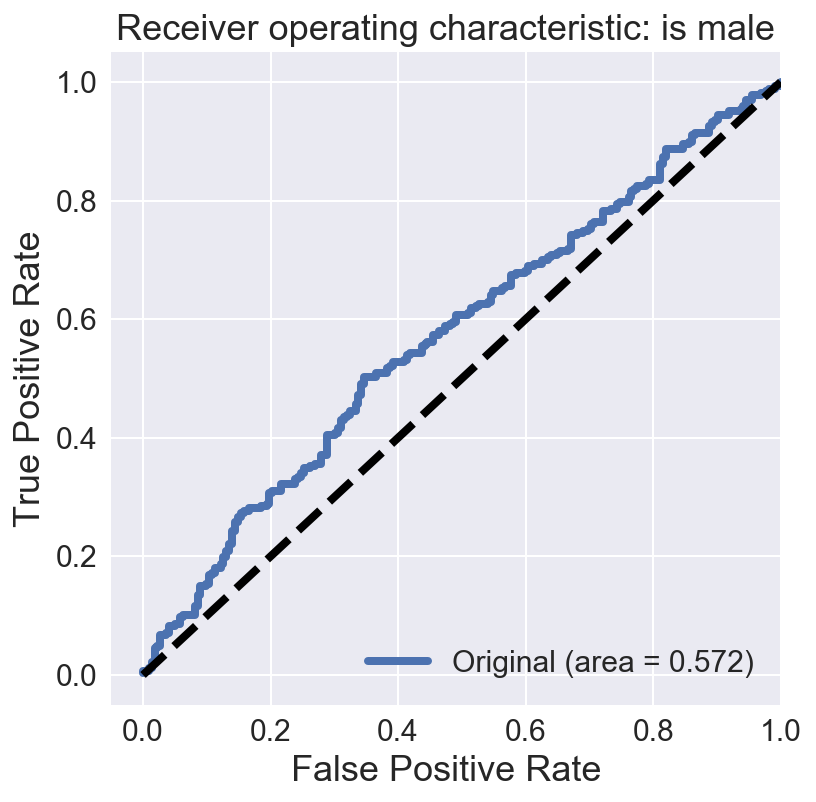

In [30]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(fpr, tpr, label='Original (area = %0.3f)' % roc_auc, linewidth=4)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)

ax.set_xlim([-0.05, 1.0])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.set_ylabel('True Positive Rate', fontsize=18)
ax.set_title('Receiver operating characteristic: is male', fontsize=18)
ax.legend(loc="lower right")

plt.show()

### 9. Cross-validate a logistic regression with a Ridge penalty.

Logistic regression can also use the Ridge penalty. Sklearn's [`LogisticRegressionCV`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) class will help you cross-validate an appropriate regularization strength.

**Important `LogisticRegressionCV` arguments:**
- `penalty`: this can be one of `'l1'` or `'l2'`. L1 is the Lasso, and L2 is the Ridge.
- `Cs`: How many different (automatically-selected) regularization strengths should be tested.
- `cv`: How many cross-validation folds should be used to test regularization strength.
- `solver`: When using the lasso penalty, this should be set to `'liblinear'`

> **Note:** The `C` regularization strength is the *inverse* of alpha. That is to say, `C = 1./alpha`

In [31]:
from sklearn.linear_model import LogisticRegressionCV

In [32]:
lr_ridge = LogisticRegressionCV(
    penalty='l2', Cs=100, cv=kf, scoring='accuracy')
lr_ridge.fit(X_train, y_train)

print(lr_ridge.C_)
print(lr_ridge.score(X_train, y_train))
print(lr_ridge.score(X_test, y_test))

[0.00869749]
0.6864754098360656
0.5848670756646217


#### 9.B Calculate the predicted labels and predicted probabilities on the test set with the Ridge logisitic regression.

In [33]:
yhat_ridge = lr_ridge.predict(X_test)
yhat_pp_ridge = lr_ridge.predict_proba(X_test)

#### 9.C Construct the confusion matrix for the Ridge LR.

In [34]:
yhat_ridge, yhat_pp_ridge, confusion_ridge = predictions_confusion(
    lr_ridge, X_test, y_test)
confusion_ridge

,predicted_male,predicted_female
is_male,195,72
is_female,131,91


### 10. Plot the ROC curve for the original and Ridge logistic regressions on the same plot.

Which performs better?

In [35]:
fpr_ridge, tpr_ridge, threshold = roc_curve(y_test, yhat_pp_ridge[:, 1])
roc_auc_ridge = auc(fpr_ridge, tpr_ridge)

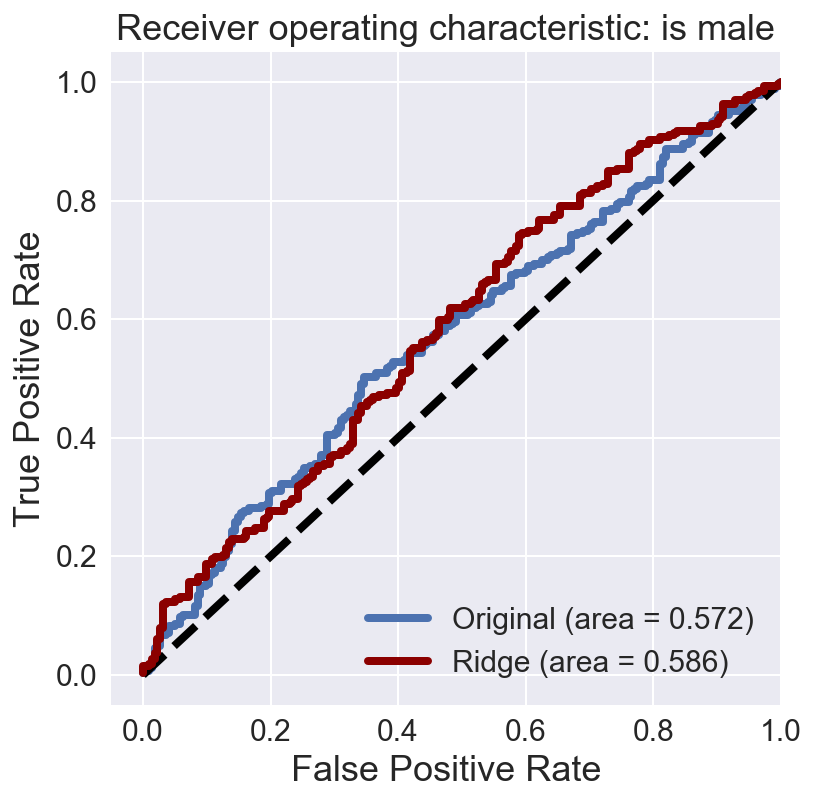

In [36]:
ax.plot(fpr_ridge, tpr_ridge, label='Ridge (area = %0.3f)' % roc_auc_ridge,
        linewidth=4, color='darkred')
ax.legend(loc='lower right')
fig

They perform the same on the training/testing set.

### 11. Cross-validate a Lasso logistic regression.

**Hint:**
- `penalty` must be set to `'l1'`
- `solver` must be set to `'liblinear'`

> **Note:** The lasso penalty can be considerably slower. You may want to try fewer Cs or use fewer cv folds.

In [37]:
lr_lasso = LogisticRegressionCV(
    penalty='l1', solver='liblinear', Cs=100, cv=kf)
lr_lasso.fit(X_train, y_train)

print(lr_lasso.C_)
print(lr_lasso.score(X_train, y_train))
print(lr_lasso.score(X_test, y_test))

[0.43287613]
0.6926229508196722
0.5603271983640081


### 12. Make the confusion matrix for the Lasso model.

In [38]:
yhat_lasso, yhat_pp_lasso, confusion_lasso = predictions_confusion(
    lr_lasso, X_test, y_test)
confusion_lasso

,predicted_male,predicted_female
is_male,171,96
is_female,119,103


### 13. Plot all three logistic regression models on the same ROC plot.

Which is the best? (if any)

In [39]:
fpr_lasso, tpr_lasso, thresholds = roc_curve(y_test, yhat_pp_lasso[:, 1])
roc_auc_lasso = auc(fpr_lasso, tpr_lasso)

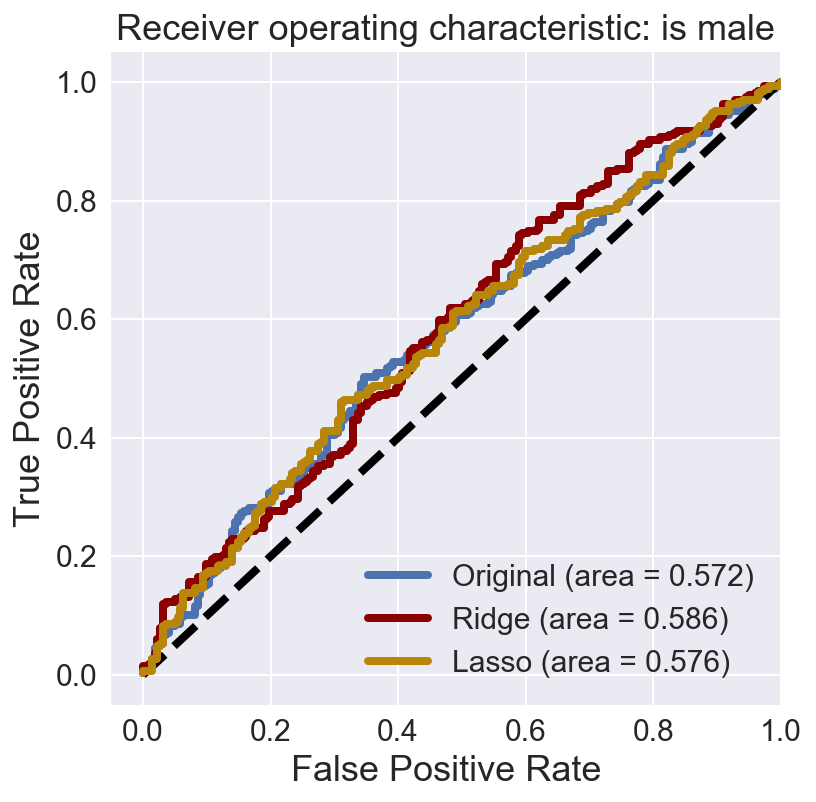

In [40]:
ax.plot(fpr_lasso, tpr_lasso, label='Lasso (area = %0.3f)' % roc_auc_lasso,
        linewidth=4, color='darkgoldenrod')
ax.legend(loc='lower right')
fig

### 14. Look at the coefficients for the Lasso logistic regression model. Which variables are the most important?

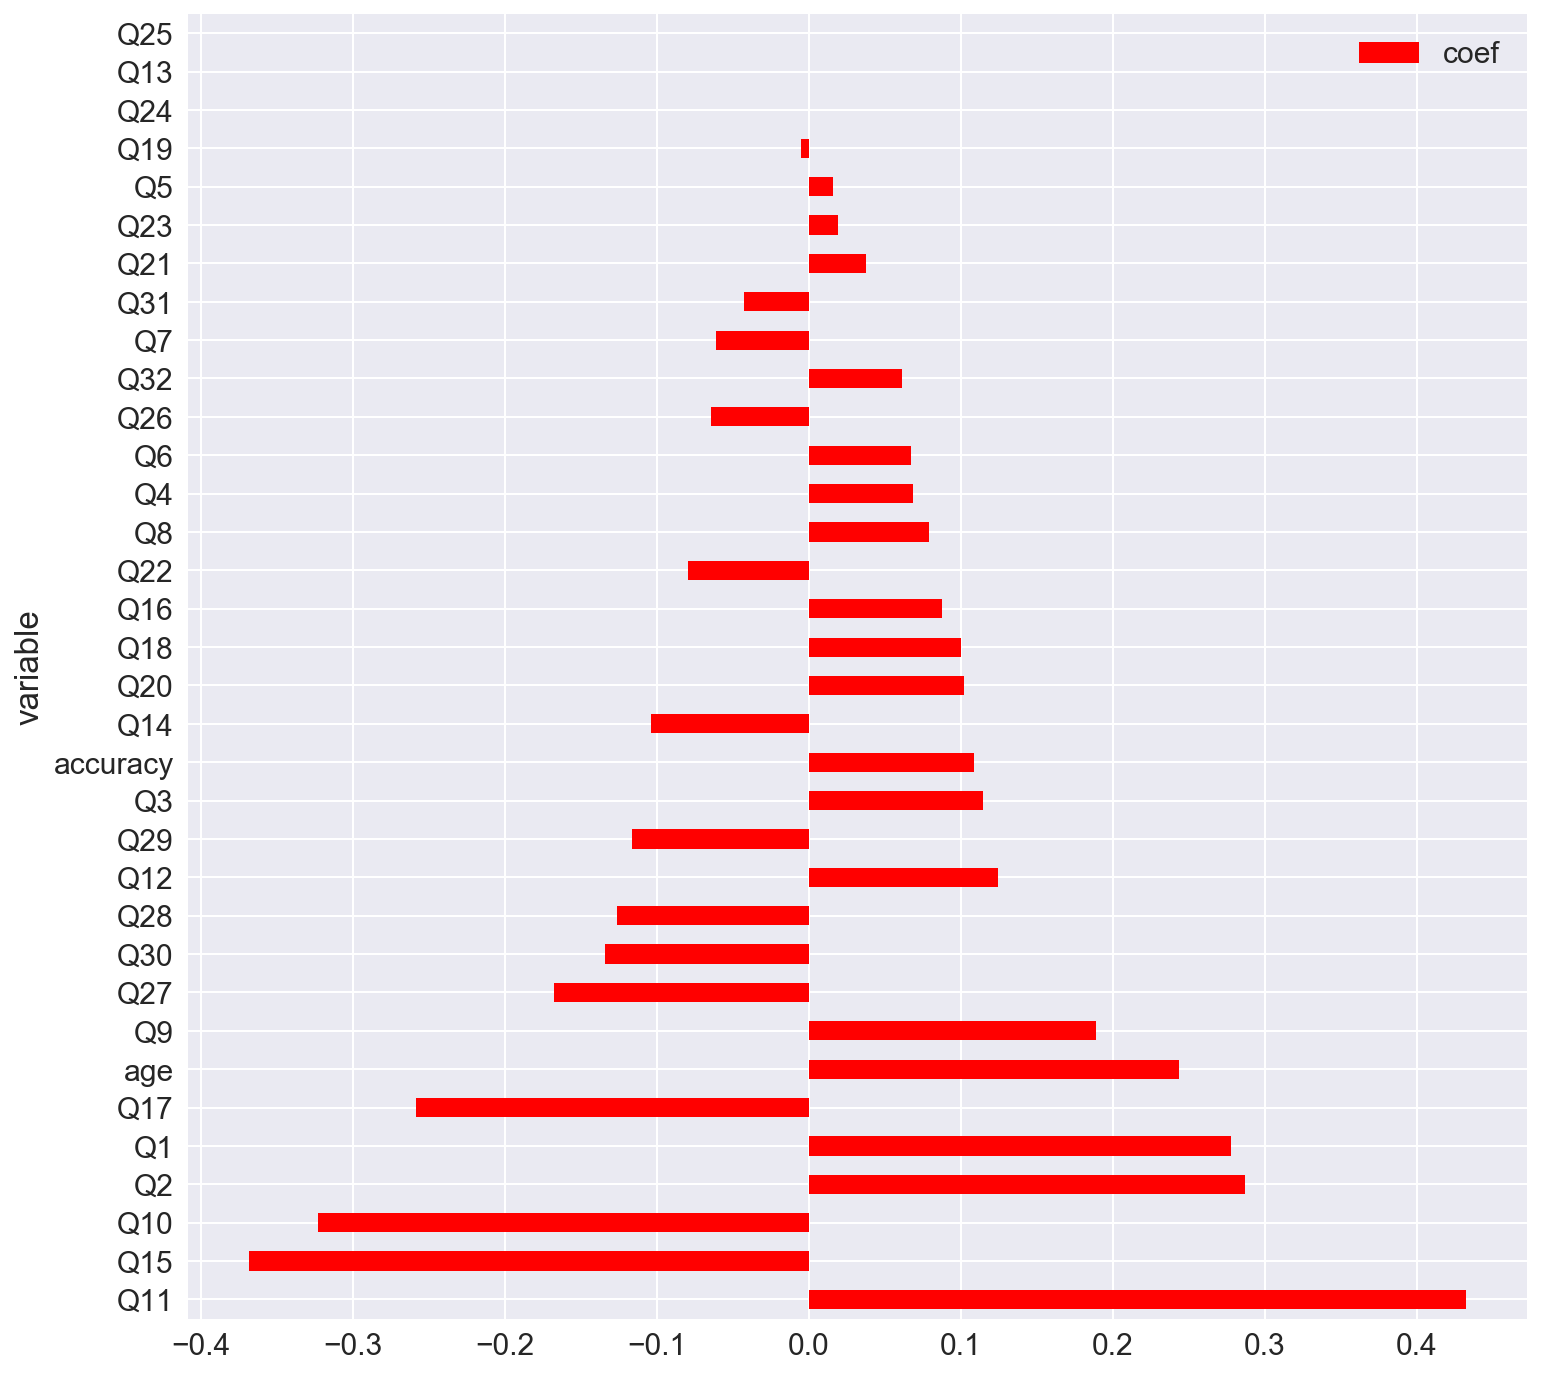

In [41]:
coefs_vars_lasso = pd.DataFrame({
    'coef': lr_lasso.coef_[0],
    'variable': X.columns,
    'abscoef': np.abs(lr_lasso.coef_[0])
})
coefs_vars_lasso.sort_values('abscoef', ascending=False, inplace=True)
coefs_vars_lasso.plot(kind='barh',x='variable',y='coef',color='r',figsize=(12,12))
plt.show()

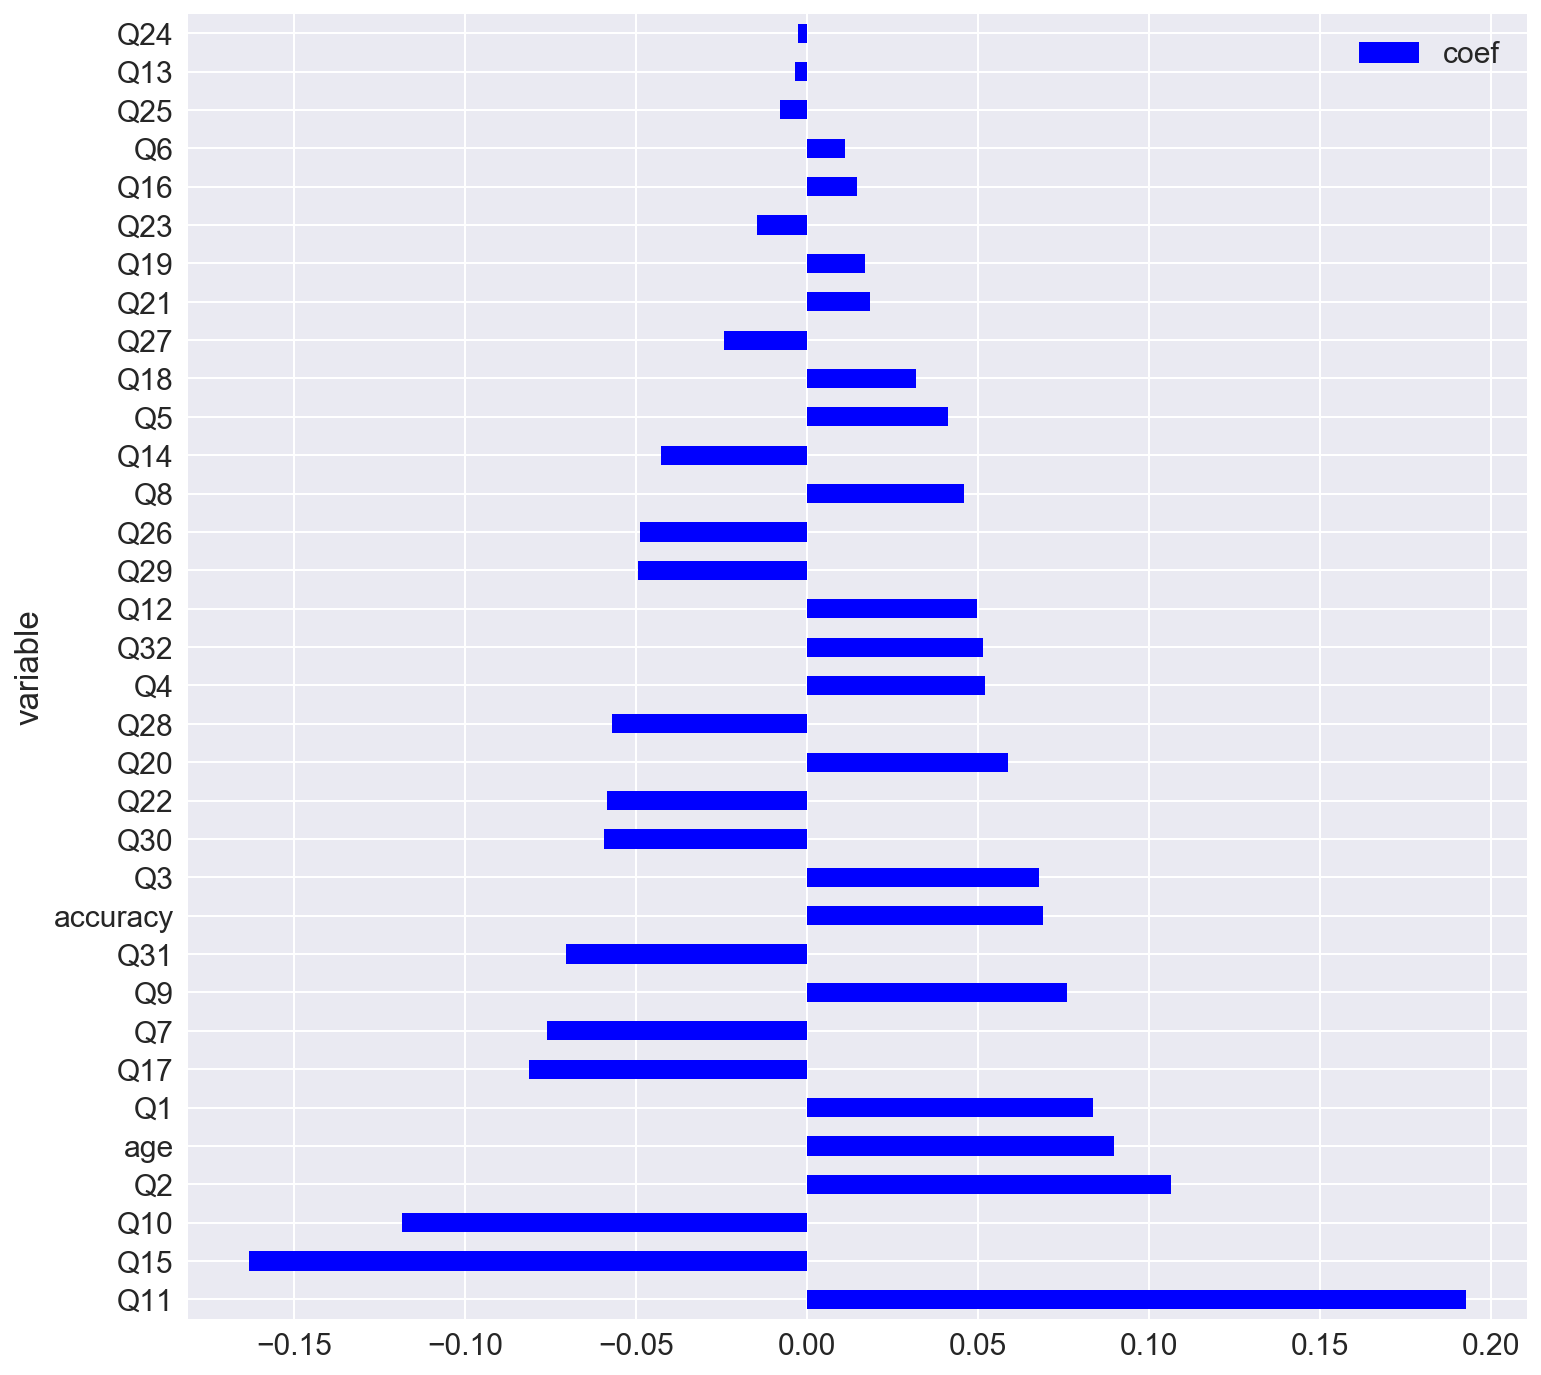

In [42]:
coefs_vars_ridge = pd.DataFrame({
    'coef': lr_ridge.coef_[0],
    'variable': X.columns,
    'abscoef': np.abs(lr_ridge.coef_[0])
})
coefs_vars_ridge.sort_values('abscoef', ascending=False, inplace=True)
coefs_vars_ridge.plot(kind='barh',x='variable',y='coef',color='b',figsize=(12,12))
plt.show()

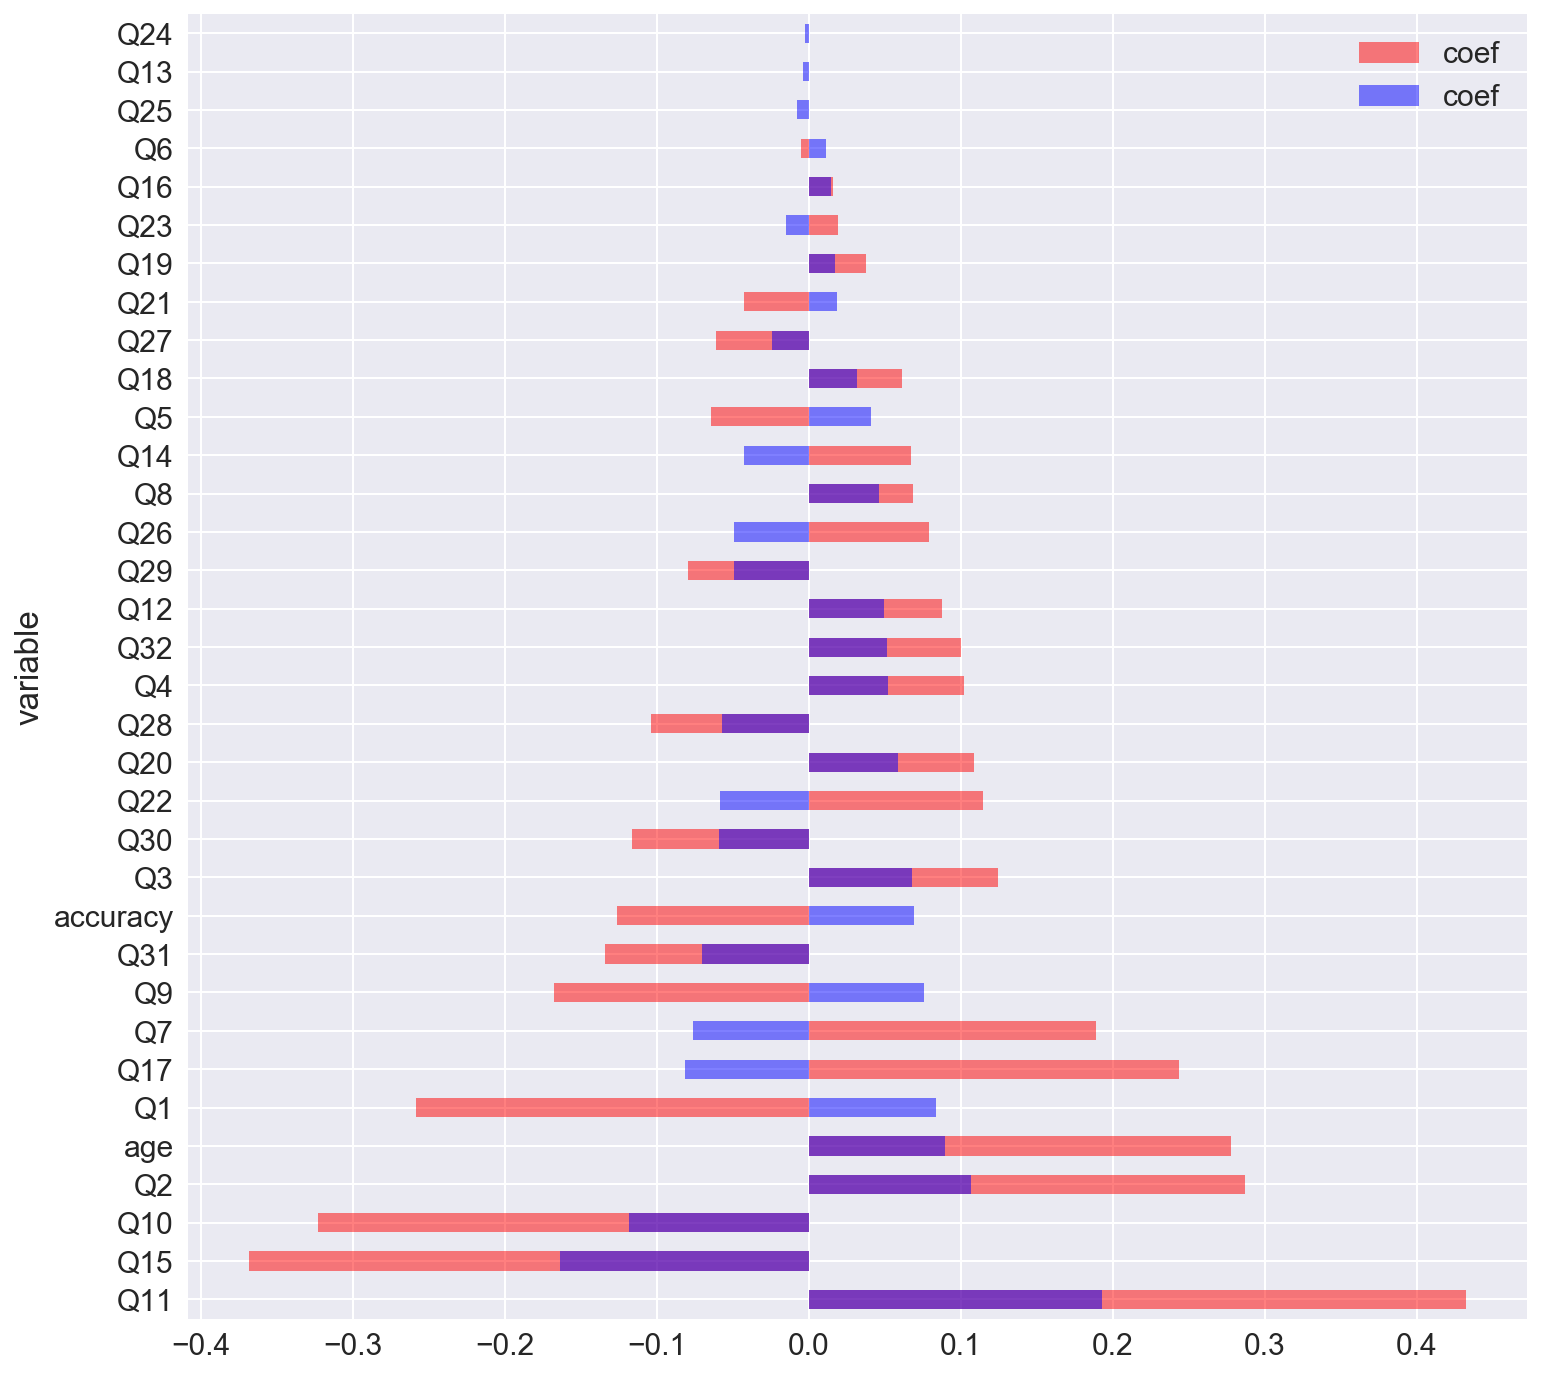

In [43]:
ax = coefs_vars_lasso.plot(kind='barh',x='variable',y='coef',color='r',figsize=(12,12),alpha=0.5)
coefs_vars_ridge.plot(kind='barh',x='variable',y='coef',color='b',figsize=(12,12), ax=ax,alpha=0.5)
plt.show()